# <center>CS 4331 - Data Mining</center>
## <center>Spring 2020</center>
### <center>Project 1</center>
#### <center>Joshua Ball | Dipendra Yadav</center>

In [3]:
# Importing the libraries and dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.cluster import KMeans
#import seaborn as sns

In [4]:
# Reading the data and displaying the first 5 rows
dataset = pd.read_csv("hotel_bookings.csv")
dataset.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


## Problem Understanding Phase


### Problem Objective
    Traveling is expensive overall, but one of the biggest costs associated with a trip is often the lodging.
    Studies have suggested that the best time to buy a plane ticket for lower-price options is 70 days in advance.
    But does the same reasoning apply to hotel rooms?

### Can this problem be solved using Data Science?
    We are using data from https://www.kaggle.com/ekretsch/hotel-booking-dataset to develop a clustering algorithm 
    that can find out the best time of the year to book a hotel room in order to get best prices in the market.

## Data Preparation Phase
    Preparing the data for analysis


In [40]:
# Cleaning the dataset (looking for outliers and NaN values)
data_size = dataset.shape
print('The size of the dataset is {}'.format(data_size))


# Checking for NaNs in the dataset
print('The attributes with NaNs are as follows:')
NaNs = pd.DataFrame(dataset.isnull().sum())
NaNs

The size of the dataset is (119390, 32)
The attributes with NaNs are as follows:


,0
hotel,0
is_canceled,0
lead_time,0
arrival_date_year,0
arrival_date_month,0
arrival_date_week_number,0
arrival_date_day_of_month,0
stays_in_weekend_nights,0
stays_in_week_nights,0
adults,0


    Here we can see there are so many instances in attributes in country, agent, and company that carries NaNs. For this project, country, agent, and company columns do not add up to the value or contribute to the fluctuation in the pricing over the year. Therefore, we are going to drop these two columns. However, We would have needed to do some interpolation to fill in these values in the data preparation phase of data mining in case these attributes were important in the formation of clusters for this project.

In [5]:
dataset = dataset.drop(columns = ['country','agent', 'company'])

# Validation of the dataset 
print('The cleaned dataset without NaNs are as follows:')
new_data = pd.DataFrame(dataset.isnull().sum())
new_data

The cleaned dataset without NaNs are as follows:


,0
hotel,0
is_canceled,0
lead_time,0
arrival_date_year,0
arrival_date_month,0
arrival_date_week_number,0
arrival_date_day_of_month,0
stays_in_weekend_nights,0
stays_in_week_nights,0
adults,0


In [6]:
#Calculating average rate paid per total stay by multiplying average daily rate * total time stayed
dataset['rate_per_stay'] = dataset['adr'] * (dataset['stays_in_weekend_nights'] + dataset['stays_in_week_nights'])

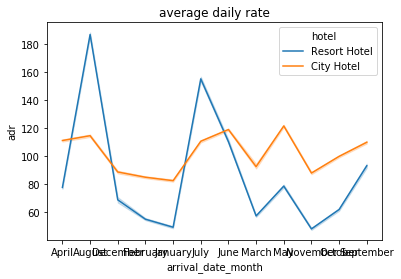

Text(0.5,1,'rate_per_stay')

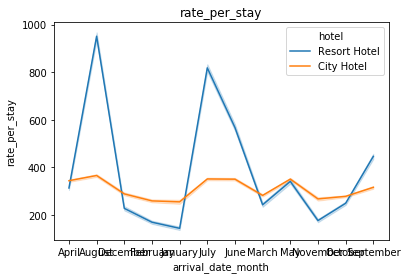

In [6]:
sns.lineplot(data = dataset, x = 'arrival_date_month', y = 'adr', hue = 'hotel').set_title("average daily rate")
plt.show()
sns.lineplot(data = dataset, x = 'arrival_date_month', y = 'rate_per_stay', hue = 'hotel').set_title("rate_per_stay")    

In [10]:
#Graphs show a clear trend where certian months have a higher overall price paid and adr

In [29]:
#Changing months from str -> int so it is no longer categorical and can be used in clustering model
#Code isn't working inside Jupyter but works in a regular enviorment so we will just read in a new corrected file.

#month_map = {'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,
             #'September':9,'October':10,'November':11,'December':12}
#dataset['arrival_date_month'] = dataset['arrival_date_month'].map(month_map)
dataset = pd.read_csv("hotel_bookings_month_corrected.csv")

In [53]:
#Next we are removing cases where the customer canceled their reservations
dataset.loc[dataset['is_canceled'] == 1] = np.NaN #Replace row with NaN if it was canceled
dataset = dataset.dropna(); #Remove NaN rows
dataset.reset_index(drop=True);

Text(0.5,1,'Cleaned rate per stay')

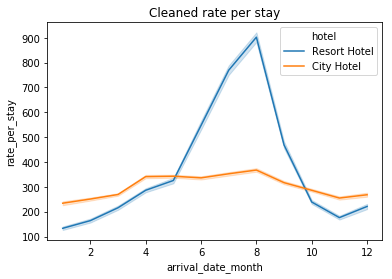

In [54]:
sns.lineplot(data = dataset, x = 'arrival_date_month', y = 'rate_per_stay', hue = 'hotel').set_title("Cleaned rate per stay")    
#Huge peak in summer months, which is to be expected.

In [55]:
def clusterMonth(RATE):
    X_month = dataset[[RATE,'arrival_date_month']]
    Xz_month = pd.DataFrame(stats.zscore(X_month),columns=[RATE,'arrival_date_month'])
    kmeans_month = KMeans(n_clusters=2).fit(Xz_month)
    cluster_month = kmeans_month.labels_
    Cluster1_month = Xz_month.loc[cluster_month  == 0]
    Cluster2_month = Xz_month.loc[cluster_month  == 1]
    print(Cluster1_month.describe())
    print(Cluster2_month.describe())
    return Cluster1_month, Cluster2_month

In [56]:
clusters = clusterMonth('rate_per_stay')

       rate_per_stay  arrival_date_month
count   34133.000000        34133.000000
mean       -0.296881           -0.919322
std         0.553537            0.513782
min        -1.268863           -1.752439
25%        -0.736726           -1.435333
50%        -0.389815           -0.801122
75%         0.007585           -0.484016
max         4.605089            0.150196
       rate_per_stay  arrival_date_month
count   41033.000000        41033.000000
mean        0.246958            0.764731
std         1.201125            0.569583
min        -1.071248           -1.752439
25%        -0.544686            0.467301
50%        -0.117242            0.784407
75%         0.650919            1.101513
max        22.438189            1.735724


In [57]:
#Validating cluster results by running k-means clustering on test data set
dataset_test = dataset
X_test = dataset_test[['rate_per_stay','arrival_date_month']]
Xz_test = pd.DataFrame(stats.zscore(X_test),columns=['rate_per_stay','arrival_date_month'])

In [58]:
kmeans_test = KMeans(n_clusters=2).fit(Xz_test)
cluster_test =kmeans_test.labels_
Cluster1_test = Xz_test.loc[cluster_test == 0]
Cluster2_test = Xz_test.loc[cluster_test == 1]
print(Cluster1_test.describe())
print(Cluster2_test.describe())

       rate_per_stay  arrival_date_month
count   34138.000000        34138.000000
mean       -0.296829           -0.919203
std         0.553534            0.513841
min        -1.268863           -1.752439
25%        -0.736726           -1.435333
50%        -0.389815           -0.801122
75%         0.007585           -0.484016
max         4.605089            0.150196
       rate_per_stay  arrival_date_month
count   41028.000000        41028.000000
mean        0.246981            0.764837
std         1.201188            0.569536
min        -1.071248           -1.752439
25%        -0.544686            0.467301
50%        -0.117242            0.784407
75%         0.650919            1.101513
max        22.438189            1.735724


In [59]:
#Clustering results of data set vs test data set looks great